In [1]:
from astropy.table import QTable, Table, Column
from astropy.coordinates import SkyCoord
import astropy.units as u
from photutils.aperture import SkyEllipticalAperture
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from matplotlib.colors import SymLogNorm
from pylab import figure, cm
from astropy import visualization
from photutils.aperture import aperture_photometry
import numpy as np
from radio_beam import Beam
from scipy.integrate import quad

In [2]:
base = '/orange/adamginsburg/sgrb2/NB/catalog/'
lowres = Table.read(base+'lowres_cat.txt', format='ipac')
lowres = lowres[lowres['sum']!=0]
catB3 = Table.read(base+'catalogB3_review_Nazar.csv', format='ascii')
catB6 = Table.read(base+'catalogB6_review_Nazar.csv', format='ascii')
catB3_new=catB3[catB3['score']!=0]
catB6_new=catB6[catB6['score']!=0]

In [3]:
def cats_matched_flux(my_cat,G_cat):
    blrr = []
    for i in range(len(G_cat)):
        if G_cat['name'][i] in my_cat['G2018']:
            blrr += [True]
        else:
            blrr += [False]
    G_cat_matched = G_cat[blrr]
    
    blrr = []
    for i in range(len(my_cat)):
        if my_cat['G2018'][i] in G_cat_matched['name']:
            blrr += [True]
        else:
            blrr += [False]
    my_cat_matched = my_cat[blrr]
    

    G_cat_matched.sort('name')
    my_cat_matched.sort('G2018')
    
    tempar = []
    prev = 0
    for i in range(len(my_cat_matched)):
        if prev == my_cat_matched['G2018'][i]:
            tempar[-1]=tempar[-1]+my_cat_matched['flux'][i]
        else:
            tempar += [my_cat_matched['flux'][i]]
        prev = my_cat_matched['G2018'][i]

    return tempar, G_cat_matched['peak'], my_cat_matched, G_cat_matched

In [4]:
my_cat_flux, G_cat_peak, my_cat, G_cat = cats_matched_flux(catB3_new,lowres)

/blue/adamginsburg/adamginsburg/repos/astropy/astropy/table/column.py:329: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(Column, self), op)(other)
/home/adamginsburg/.local/lib/python3.9/site-packages/numpy/ma/core.py:4076: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = compare(sdata, odata)


In [5]:
path = base+'NB3.fits'
path1 = base+'MB3.fits'
path2 = base+'SgrB2_selfcal_full_TCTE7m_selfcal6_ampphase_taylorterms_multiscale_deeper_mask1.5mJy.image.tt0.pbcor.fits'
hdu = fits.open(path)[0]
hdu1 = fits.open(path1)[0]
hdu2 = fits.open(path2)[0]

In [6]:
data = u.Quantity(hdu.data, unit=hdu.header['BUNIT'])
data1 = u.Quantity(hdu1.data, unit=hdu1.header['BUNIT'])
#data = data[1000:-1000,1000:-1000]
#hdu.header.update(wcs[1000:-1000,1000:-1000].to_header())

#data1 = data1[1000:-1000,1000:-1000]
#hdu1.header.update(wcs1[1000:-1000,1000:-1000].to_header())
wcs = WCS(hdu.header)
wcs1 = WCS(hdu1.header)

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [7]:
positions = SkyCoord(G_cat['RA'],G_cat['Dec'], unit='deg', frame='fk5')
#aper = SkyEllipticalAperture(positions, hdu2.header['BMAJ']*u.deg, hdu2.header['BMIN']*u.deg,hdu2.header['BPA']*u.deg)
fctr = 1/(8*np.log(2))
Bmaj = hdu2.header['BMAJ']*u.deg*np.sqrt(fctr)
Bmin = hdu2.header['BMIN']*u.deg*np.sqrt(fctr)
aper = SkyEllipticalAperture(positions, Bmaj,Bmin,hdu2.header['BPA']*u.deg)


Bmaj = hdu.header['BMAJ']*u.deg*np.sqrt(fctr)
Bmin = hdu.header['BMIN']*u.deg*np.sqrt(fctr)
pix_maj = Bmaj/(hdu.header['CDELT2']*u.deg)
pix_min = Bmin/(hdu.header['CDELT2']*u.deg)
ppb = 2*np.pi*pix_maj*pix_min

Bmaj1 = hdu1.header['BMAJ']*u.deg*np.sqrt(fctr)
Bmin1 = hdu1.header['BMIN']*u.deg*np.sqrt(fctr)
pix_maj1 = Bmaj1/(hdu1.header['CDELT2']*u.deg)
pix_min1 = Bmin1/(hdu1.header['CDELT2']*u.deg)
ppb1 = 2*np.pi*pix_maj1*pix_min1

In [8]:
(hdu2.header['BMAJ']*u.deg*np.sqrt(fctr)).to(u.arcsec)

<Quantity 0.23003142 arcsec>

In [9]:
(hdu2.header['BMIN']*u.deg*np.sqrt(fctr)).to(u.arcsec)

<Quantity 0.1968271 arcsec>

In [10]:
hdu2.header['BPA']

68.30076599121

In [11]:
ppb

<Quantity 20.16208874>

In [12]:
ppb1

<Quantity 20.12407329>

In [13]:
def beam_area(hdu):
    factor = 2*np.sqrt(2*np.log(2))
    major = hdu.header['BMAJ']*u.deg/factor
    minor = hdu.header['BMIN']*u.deg/factor
    area = np.pi*major*minor*2
    return area

In [14]:
my_beam = Beam.from_fits_header(hdu.header)
my_beam1 = Beam.from_fits_header(hdu1.header)
my_beam2 = Beam.from_fits_header(hdu2.header)

In [15]:
ba = beam_area(hdu).to(u.sr)
ba1 = beam_area(hdu1).to(u.sr)
ba2 = beam_area(hdu2).to(u.sr)
bNc = ba/ba2
bMc = ba1/ba2

In [16]:
ba2

<Quantity 6.68654315e-12 sr>

In [17]:
def gaussian(x, x0=0, width=1):
    return np.exp(-(x-x0)**2/(2*width**2))

fwhm = np.sqrt(8*np.log(2))
angle = fwhm*np.sqrt(fctr)
ap_cor = quad(gaussian, -np.inf, np.inf)[0]/quad(gaussian, -angle,angle)[0]

In [18]:
ap_cor

1.4647947734915436

In [19]:
ppb

<Quantity 20.16208874>

In [20]:
phot_table = aperture_photometry(data, aper, wcs=wcs) 
phot_table1 = aperture_photometry(data1, aper, wcs=wcs1) 

In [21]:
phot = phot_table['aperture_sum'].value*ap_cor/ppb
phot1 = phot_table1['aperture_sum'].value*ap_cor/ppb1

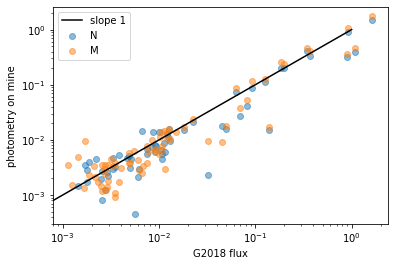

In [22]:
plt.plot([0,1],[0,1],label='slope 1',color='k')
plt.scatter(G_cat['peak'],phot,label='N',alpha=0.5)
plt.scatter(G_cat['peak'],phot1,label='M',alpha=0.5)
plt.loglog()
#plt.xlim(0.001,2)
#plt.ylim(0.0001,100)
plt.ylabel('photometry on mine')
plt.xlabel('G2018 flux')
plt.legend()

In [23]:
err = (np.array(G_cat['peak'])-phot)/np.array(G_cat['peak'])*100
errabs = np.absolute(err)
err1 = (np.array(G_cat['peak'])-phot1)/np.array(G_cat['peak'])*100
err1abs = np.absolute(err1)

In [24]:
#G_cat.add_column(err,index=0,name='errN')
#G_cat.add_column(err1,index=1,name='errM')

In [25]:
G_cat[np.where(G_cat['name']=='core_102')]

name,RA,Dec,peak,sum,alpha,alphaerror,npix,beam_area,bgmad,color,peak_mass_20K,peak_col_20K,peak_mass_40K,peak_col_40K,peak_90GHz,sum_90GHz,bgmad_90GHz,peak_100GHz,sum_100GHz,bgmad_100GHz,peak_K,SIMBAD_ID,SIMBAD_OTYPE,Caswell_Name,Caswell_V_CH3OH,Caswell_matchdistance,McGrath_V_H2O,McGrath_matchdistance,Muno_xray_ID,Muno_xray_Counts,Muno_xray_matchdistance,nn11,radius,Cluster,Classification
,deg,deg,Jy / beam,Jy / beam,,,,sr,Jy / beam,,solMass,1 / cm2,solMass,1 / cm2,,,,,,,K,,,,km / s,arcsec,km / s,arcsec,,1 / (cm2 s),arcsec,deg,,,
str16,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str24,str11,str11,float64,float64,float64,float64,str15,float64,float64,float64,float64,str2,str19
core_102,266.825441667,-28.3686027778,0.00857824925333,0.179342183808,1.18122637272,1.00739204884,47.0,6.68830907334e-12,8.65678976725e-05,green,306.630055426,3.34047174021e+25,144.464163787,1.45351371991e+25,0.0076988665387,0.146371900162,0.000462590300969,0.00695632398129,0.106307511909,0.00116911289668,4.49785552383,[GCD95] X08.33,HII,-,nan,nan,nan,nan,-,nan,nan,0.00386155396041,nan,--,S\_\_\_ HII


(array([ 4.,  0.,  2.,  3.,  5., 20., 10.,  8.,  5.,  4.]),
 array([-123.40585689, -100.15353511,  -76.90121334,  -53.64889156,
         -30.39656979,   -7.14424801,   16.10807376,   39.36039554,
          62.61271731,   85.86503909,  109.11736087]),
 <BarContainer object of 10 artists>)

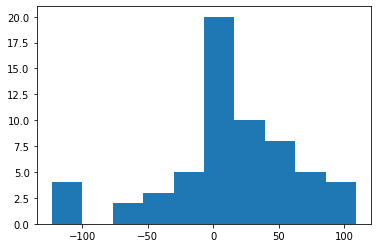

In [26]:
#err = err[~np.isnan(err)]
plt.hist(err.value)

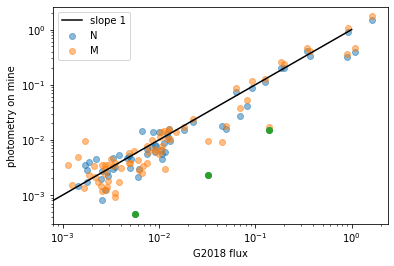

In [27]:
plt.plot([0,1],[0,1],label='slope 1',color='k')
plt.scatter(G_cat['peak'],phot,label='N',alpha=0.5)
plt.scatter(G_cat['peak'],phot1,label='M',alpha=0.5)
plt.loglog()
#plt.xlim(0.001,2)
#plt.ylim(0.0001,100)
plt.ylabel('photometry on mine')
plt.xlabel('G2018 flux')
plt.scatter(G_cat[np.where(err>70)]['peak'], phot[np.where(err>70)])
#plt.scatter(G_cat[np.where(err1abs<10)]['peak'], phot1[np.where(err1abs<10)])
#plt.scatter(G_cat[np.where(err_abs < 10)]['peak'], phot1[np.where(err_abs < 10)],)
plt.legend()

In [28]:
G_cat[np.where((errabs<20) | (err1abs<20))]

name,RA,Dec,peak,sum,alpha,alphaerror,npix,beam_area,bgmad,color,peak_mass_20K,peak_col_20K,peak_mass_40K,peak_col_40K,peak_90GHz,sum_90GHz,bgmad_90GHz,peak_100GHz,sum_100GHz,bgmad_100GHz,peak_K,SIMBAD_ID,SIMBAD_OTYPE,Caswell_Name,Caswell_V_CH3OH,Caswell_matchdistance,McGrath_V_H2O,McGrath_matchdistance,Muno_xray_ID,Muno_xray_Counts,Muno_xray_matchdistance,nn11,radius,Cluster,Classification
,deg,deg,Jy / beam,Jy / beam,,,,sr,Jy / beam,,solMass,1 / cm2,solMass,1 / cm2,,,,,,,K,,,,km / s,arcsec,km / s,arcsec,,1 / (cm2 s),arcsec,deg,,,
str16,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str24,str11,str11,float64,float64,float64,float64,str15,float64,float64,float64,float64,str2,str19
core_103,266.827116667,-28.3698333333,0.00907186605036,0.293650600128,4.7069978714,0.798583328724,52.0,6.68830907334e-12,0.00125292983649,green,324.274418671,3.56586873601e+25,152.777041591,1.54304206118e+25,0.00876395776868,0.291205066023,0.000964897470483,0.00892541930079,0.263080821373,0.00037032578667,4.7566748903,-,-,-,nan,nan,nan,nan,-,nan,nan,0.00303451432398,nan,--,S\_\_\_ -
core_104,266.826654167,-28.3697055556,0.00507354224101,0.159569426556,3.47850513458,0.509051203728,52.0,6.68830907334e-12,0.000630826675707,green,181.354084339,1.8562635974e+25,85.4422639911,8.37221083944e+24,0.00453815050423,0.1359854599,0.000365200716258,0.00421722186729,0.10169376569,0.000393476218392,2.66022346987,-,-,-,nan,nan,nan,nan,-,nan,nan,0.0033589436705,nan,--,S\_\_\_ -
core_105,266.825966667,-28.3695666667,0.00181067921221,0.0482482508814,2.07058095932,3.73277950287,50.0,6.68830907334e-12,0.000146023913965,green,64.72284155,6.28506174094e+24,30.4931986182,2.91818778529e+24,0.00123367377091,0.0298480237216,0.000265203785685,0.00067603396019,-0.0168478536318,0.000969056210002,0.949398094649,-,-,-,nan,nan,nan,nan,-,nan,nan,0.00372186885943,nan,--,S\_\_\_ -
core_107,266.830066667,-28.3699833333,0.00933190342039,0.278049934306,3.62005329132,0.83007222414,52.0,6.68830907334e-12,0.000763880278081,green,333.569470707,3.68641642738e+25,157.156266314,1.5904886002e+25,0.00761144794524,0.237477835966,0.000354031191089,0.0107716256753,0.296216618968,0.000760456286606,4.89302095424,-,-,-,nan,nan,nan,nan,-,nan,nan,0.00253278601503,nan,--,S\_\_\_ -
core_108,266.83025,-28.3708333333,0.0123311970383,0.313586416421,3.48185324669,0.417881965637,50.0,6.68830907334e-12,0.00105303729014,green,440.779408439,5.17711774222e+25,207.666624741,2.15244181505e+25,0.0118605401367,0.33735038829,0.00122365348394,0.013710539788,0.357916010777,0.0010076987447,6.46564830144,NAME Sgr B2 Maser F,Maser,0.677-0.025,73.3000030518,0.331177682073,65.4000015259,0.313903761666,-,nan,nan,0.00235482141781,nan,N,S\_MW Maser
core_111,266.8312875,-28.3707111111,0.00752501934767,0.265174738131,4.56552028656,2.00467991829,51.0,6.68830907334e-12,0.00236961732968,green,268.982286655,2.87388047715e+25,126.726980697,1.26479552824e+25,0.00666617089882,0.234339762479,0.00171545666468,0.00905358884484,0.304990474833,0.0025556924014,3.94561277486,-,-,-,nan,nan,nan,nan,-,nan,nan,0.00159656742863,nan,N,S\_\_\_ -
core_113,266.83185,-28.3734555556,0.00849447678775,0.234398504486,2.17025637627,1.94831037521,50.0,6.68830907334e-12,0.000642894830355,green,303.635603411,3.30265577751e+25,143.053372513,1.43838895931e+25,0.00654339091852,0.163597814972,0.000407860891922,0.00899642053992,0.248823444126,0.000373820370569,4.4539308912,-,-,-,nan,nan,nan,nan,-,nan,nan,0.00264568150815,nan,N,S\_\_\_ -
core_124,266.826029167,-28.394175,0.00165055808611,0.0361265768952,0.174869209528,1.22931647301,51.0,6.68830907334e-12,0.000132663812236,green,58.9993018951,5.71514946721e+24,27.7966385273,2.65710963691e+24,0.00147461635061,0.0345221531916,0.000193021046972,0.00140031857882,0.0265861540402,0.000157777336862,0.865441372217,-,-,-,nan,nan,nan,nan,-,nan,nan,0.00491328707261,nan,--,S\_\_\_ -


Text(0.5, 0, 'G2018 flux')

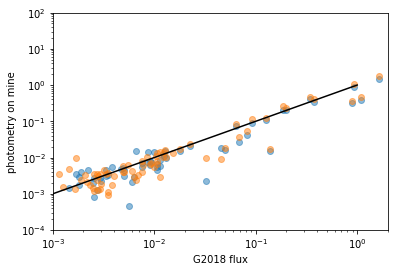

In [29]:
plt.plot([0,1],[0,1],label='slope 1',color='k')
plt.scatter(G_cat['peak'],phot,label='N',alpha=0.5)
plt.scatter(G_cat['peak'],phot1,label='M',alpha=0.5)
plt.loglog()
plt.xlim(0.001,2)
plt.ylim(0.0001,100)
plt.ylabel('photometry on mine')
plt.xlabel('G2018 flux')

# Find out how many sources in M, N in each catalogs

Use the regions package to find out how many sources are in each footprint

Because there's overlap, there is double-counting...

In [52]:
wcs1.wcs.crval

array([266.83405975, -28.38466334])

In [63]:
import regions
mreg = regions.CircleSkyRegion(SkyCoord(*wcs1.wcs.crval, unit=(u.deg,u.deg), frame='icrs'), radius=35*u.arcsec)
nreg = regions.CircleSkyRegion(SkyCoord(*wcs.wcs.crval, unit=(u.deg,u.deg), frame='icrs'), radius=35*u.arcsec)

we use the WCS associated with Sgr B2 M here - but technically it would be better to use the G18 WCS for the G18 positions.

However, this doesn't matter b/c reginos is just using the WCS to convert the sky coordinates (the region) to pixel coordinates to check whether the coordinates are contained within.  This is a limitation of the regions concept...

In [64]:
mreg.contains(positions, wcs=wcs1).sum()

49

In [65]:
nreg.contains(positions, wcs=wcs).sum()

26

In [66]:
positions_NB_B3 = SkyCoord(catB3['x_cen'], catB3['y_cen'], unit=(u.deg,u.deg), frame='icrs')
nreg.contains(positions_NB_B3, wcs=wcs).sum()

209

In [67]:
mreg.contains(positions_NB_B3, wcs=wcs1).sum()

169

## Handle double-counting

In [68]:
n_or_m = mreg | nreg

In principle, all sources should be in one or the other:

In [69]:
n_or_m.contains(positions_NB_B3, wcs=wcs).sum()

350

In [70]:
len(positions_NB_B3)

411

In [73]:
n_or_m.contains(positions, wcs=wcs).sum()

69

So, 69 -> 350 total

There are about 60 sources outside of the 30" radius.  That's hopefully because you imaged past 30"...

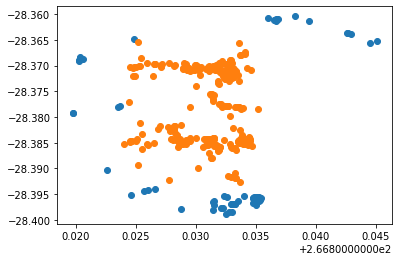

In [71]:
x = catB3[~n_or_m.contains(positions_NB_B3, wcs=wcs)]
y = catB3[n_or_m.contains(positions_NB_B3, wcs=wcs)]

plt.scatter(x['x_cen'], x['y_cen'])
plt.scatter(y['x_cen'], y['y_cen'])